## Creating a cross-model ensemble using STAC

This tutorial builds a cross-collection ensemble of GDPCIR bias corrected and downscaled data, and plots a single variable time series for the ensemble.

In [1]:
# required to locate and authenticate with the stac collection
import planetary_computer
import pystac_client

# required to load a zarr array using xarray
import xarray as xr

# optional imports used in this notebook
import pandas as pd
from dask.diagnostics import ProgressBar
from tqdm.auto import tqdm

### Understanding the GDPCIR collections

The [CIL-GDPCIR datsets](https://planetarycomputer.microsoft.com/dataset/group/cil-gdpcir) are grouped into several collections, depending on the license the data are provided under.

- [CIL-GDPCIR-CC0](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc0) - provided in public domain using a [CC 1.0 Universal Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/)
- [CIL-GDPCIR-CC-BY](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc-by) - provided under a [CC Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/)
- [CIL-GDPCIR-CC-BY-SA](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc-by-sa) - provided under a [CC Attribution-ShareAlike 4.0 License](https://creativecommons.org/licenses/by-sa/4.0/)

Note that the first group, CC0, places no restrictions on the data. The second two (CC-BY and CC-BY-SA) require citations of the climate models these datasets are derived from, and the third group, shared under a CC-BY-SA 4.0 license, requires that derived works (that means your work!) be shared under the same license. See the [ClimateImpactLab/downscaleCMIP6 README](github.com/ClimateImpactLab/downscaleCMIP6) for the citation information for each GCM.

Also, note that none of the descriptions of these licenses on this page, in this repository, and associated with this repository constitute legal advice. We are highlighting some of the key terms of these licenses, but this information should not be considered a replacement for the actual license terms, which are provided on the Creative Commons website at the links above.

### Structure of the STAC collection

The data assets in this collection are a set of [Zarr](https://zarr.readthedocs.io/) groups which can be opend by tools like [xarray](https://xarray.pydata.org/). Each Zarr group contains a single data variable (either `pr`, `tasmax`, or `tasmin`). The Planetary Computer provides a single STAC item per experiment, and each STAC item has one asset per data variable.

Altogether, the collection is just over 21TB, with 247,997 individual files. The STAC collection is here to help search and make sense of this huge archive!

For example, let's take a look at the CC0 collection:

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
collection_cc0 = catalog.get_collection("cil-gdpcir-cc0")
collection_cc0

<CollectionClient id=cil-gdpcir-cc0>

In [3]:
collection_cc0.summaries.to_dict()

{'cmip6:variable': ['pr', 'tasmax', 'tasmin'],
 'cmip6:source_id': ['FGOALS-g3', 'INM-CM4-8', 'INM-CM5-0'],
 'cmip6:experiment_id': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'cmip6:institution_id': ['BCC',
  'CAS',
  'CCCma',
  'CMCC',
  'CSIRO',
  'CSIRO-ARCCSS',
  'DKRZ',
  'EC-Earth-Consortium',
  'INM',
  'MIROC',
  'MOHC',
  'MPI-M',
  'NCC',
  'NOAA-GFDL',
  'NUIST']}

The CC0 (Public Domain) collection has three models, from which a historical scenario and four future simulations are available. 

*Note that not all models provide all simulations. See the [ClimateImpactLab/downscaleCMIP6 README](https://github.com/ClimateImpactLab/downscaleCMIP6) for a list of the available model/scenario/variable combinations.*

### Querying the STAC API

Use the Planetary Computer STAC API to find the exact data you want. You'll most likely want to query on the controlled vocabularies fields, under the `cmip6:` prefix. See the collection summary for the set of allowed values for each of those.

### Combining collections to form a custom ensemble

As an example, if you would like to use both the CC0 and CC-BY collections, you can combine them as follows:

In [4]:
search = catalog.search(
    collections=["cil-gdpcir-cc0", "cil-gdpcir-cc-by"],
    query={"cmip6:experiment_id": {"eq": "ssp370"}},
)
ensemble = search.get_all_items()
len(ensemble)

19

In [5]:
import collections

collections.Counter(x.collection_id for x in ensemble)

Counter({'cil-gdpcir-cc-by': 16, 'cil-gdpcir-cc0': 3})

### Reading a single variable across models into xarray

In [6]:
# select this variable ID for all models in a collection
variable_id = "tasmax"

datasets_by_model = []

for item in tqdm(ensemble):
    asset = item.assets[variable_id]
    datasets_by_model.append(
        xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
    )

all_datasets = xr.concat(
    datasets_by_model,
    dim=pd.Index([ds.attrs["source_id"] for ds in datasets_by_model], name="model"),
    combine_attrs="drop_conflicts",
)

  0%|          | 0/19 [00:00<?, ?it/s]

In [7]:
all_datasets

,Array,Chunk
Bytes,2.25 TiB,180.45 MiB
Shape,"(19, 31390, 720, 1440)","(1, 365, 360, 360)"
Count,39235 Tasks,13072 Chunks
Type,float32,numpy.ndarray


### Subsetting the data

Now that the metadata has been loaded into xarray, you can use xarray's methods for [Indexing and Selecting Data](https://xarray.pydata.org/en/latest/user-guide/indexing.html) to extract the subset the arrays to the portions meaningful to your analysis.

Note that the data has not been read yet - this is simply working with the coordinates to schedule the task graph using [dask](https://docs.xarray.dev/en/latest/user-guide/dask.html).

In [8]:
# let's select a subset of the data for the first five days of 2020 over Japan.
# Thanks to https://gist.github.com/graydon/11198540 for the bounding box!
subset = all_datasets.tasmax.sel(
    lon=slice(129.408463169, 145.543137242),
    lat=slice(31.0295791692, 45.5514834662),
    time=slice("2020-01-01", "2020-01-05"),
)

In [9]:
with ProgressBar():
    subset = subset.compute()

[########################################] | 100% Completed | 13.55 s


In [10]:
subset

<xarray.DataArray 'tasmax' (model: 19, time: 5, lat: 58, lon: 64)>
array([[[[285.73315, 285.4604 , 285.3989 , ..., 288.46887, 288.45538,
          288.3411 ],
         [285.4088 , 284.85898, 284.64523, ..., 288.25568, 288.40067,
          288.26636],
         [285.042  , 284.65338, 284.3192 , ..., 288.09857, 288.33298,
          288.17307],
         ...,
         [255.6336 , 255.90742, 255.76608, ..., 270.9189 , 271.3525 ,
          271.49866],
         [255.53918, 256.2673 , 257.10635, ..., 271.33408, 270.98483,
          271.3151 ],
         [254.87746, 255.66376, 256.50848, ..., 271.04498, 271.05704,
          271.30338]],

        [[285.91162, 285.58484, 286.10092, ..., 292.35254, 292.3309 ,
          292.34427],
         [285.565  , 284.94022, 285.75223, ..., 292.1405 , 292.2511 ,
          292.22943],
         [285.25647, 284.79587, 285.2175 , ..., 291.90317, 292.11487,
          292.16623],
...
         [263.99496, 263.98923, 265.9909 , ..., 272.94186, 270.91608,
          271.09778],
         [263.7273 , 264.36838, 267.27963, ..., 271.01   , 270.0902 ,
          270.34082],
         [262.84192, 263.58743, 266.7099 , ..., 270.6768 , 270.26273,
          270.4232 ]],

        [[289.9362 , 289.80225, 288.88925, ..., 291.64294, 291.30453,
          291.20703],
         [289.503  , 289.25168, 288.7057 , ..., 291.51035, 291.37308,
          291.30908],
         [289.054  , 288.8851 , 287.89902, ..., 291.3675 , 291.34402,
          291.34195],
         ...,
         [265.43088, 265.4783 , 268.89062, ..., 270.09174, 269.90125,
          270.14105],
         [264.06845, 264.98584, 268.8448 , ..., 270.29214, 269.33145,
          269.47906],
         [263.4161 , 264.3746 , 268.24796, ..., 270.58902, 269.15533,
          269.333  ]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 31.12 31.38 31.62 31.88 ... 44.62 44.88 45.12 45.38
  * lon      (lon) float64 129.6 129.9 130.1 130.4 ... 144.6 144.9 145.1 145.4
  * time     (time) object 2020-01-01 12:00:00 ... 2020-01-05 12:00:00
  * model    (model) object 'GFDL-ESM4' 'NorESM2-MM' ... 'BCC-CSM2-MR'
Attributes:
    cell_measures:  area: areacella
    coordinates:    height
    interp_method:  conserve_order2
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    comment:        maximum near-surface (usually, 2 meter) air temperature (...

At this point, you could do anything you like with the data. See the great [xarray getting started guide](https://xarray.pydata.org/en/latest/getting-started-guide/quick-overview.html#) for more information. For now, we'll plot it all!

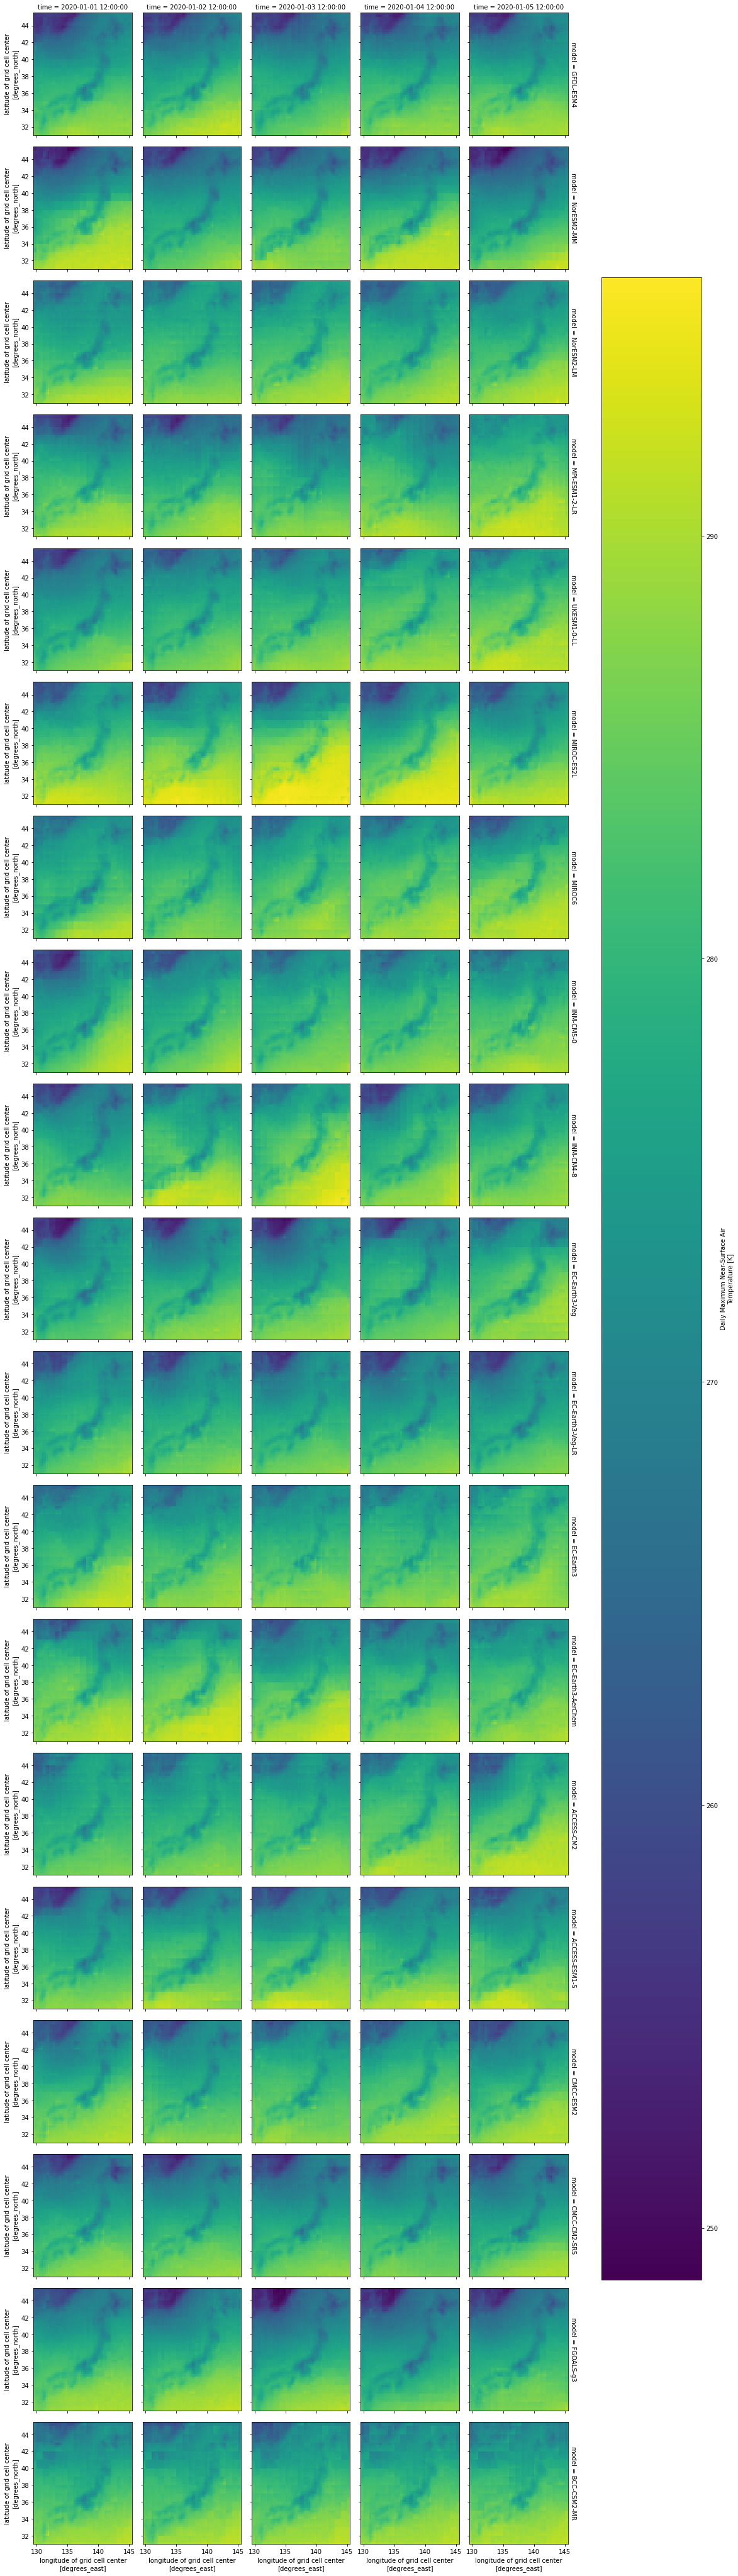

In [11]:
subset.plot(row="model", col="time");